In [1]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import madrigalWeb.madrigalWeb
import re
import os
import h5py
import numpy as np

In [2]:
#CHANGE ME
user_fullname = "Student Example"
user_email = "isr.summer.school@gmail.com"
user_affiliation = "ISR Summer School 2023"

maddat = madrigalWeb.madrigalWeb.MadrigalData('https://data.amisr.com/madrigal/')

In [3]:
#instrument codes for AMISR
instcodes={'PFISR':61,
          'RISR-N':91,
          'RISR-C':92}

In [4]:
#start time
st=datetime.datetime(2023, 6, 15, 6,0)
et=datetime.datetime(2023, 6, 15, 17,0)

expList = maddat.getExperiments(instcodes['PFISR'], st.year, st.month, st.day, st.hour, st.minute, st.second,
                                et.year, et.month, et.day, et.hour, et.minute, et.second, local=1)
for exp in expList:
    print(exp)

id: 30000425
realUrl: http://data.amisr.com/madrigal/showExperiment/?experiment_list=30000425
url: http://data.amisr.com/madrigal/madtoc/experiments0/2023/pfa/15jun23b
name: Themis36 - Auroral and convection measurements
siteid: 3
sitename: SRI
instcode: 61
instname: Poker Flat IS Radar
startyear: 2023
startmonth: 6
startday: 15
starthour: 6
startmin: 0
startsec: 44
endyear: 2023
endmonth: 6
endday: 15
endhour: 17
endmin: 59
endsec: 54
isLocal: True
madrigalUrl: http://data.amisr.com/madrigal
PI: Asti Bhatt
PIEmail: asti.bhatt@sri.com
uttimestamp: 1689272550
access: 0
Madrigal version: 3.4



In [5]:
# From the selected experiment list the available files / kind of data / description
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    print('kindat:',file.kindat, 'Description:',file.kindatdesc)

kindat: 1000203 Description: Ne From Power - Alternating Code (E-region) - 3 min
kindat: 2000203 Description: Fitted - Alternating Code (E-region) - 3 min
kindat: 1000205 Description: Ne From Power - Alternating Code (E-region) - 5 min
kindat: 2000205 Description: Fitted - Alternating Code (E-region) - 5 min
kindat: 1000210 Description: Ne From Power - Alternating Code (E-region) - 10 min
kindat: 2000210 Description: Fitted - Alternating Code (E-region) - 10 min
kindat: 1000215 Description: Ne From Power - Alternating Code (E-region) - 15 min
kindat: 2000215 Description: Fitted - Alternating Code (E-region) - 15 min
kindat: 1000220 Description: Ne From Power - Alternating Code (E-region) - 20 min
kindat: 2000220 Description: Fitted - Alternating Code (E-region) - 20 min
kindat: 1000103 Description: Ne From Power - Long Pulse (F-region) - 3 min
kindat: 2000103 Description: Fitted - Long Pulse (F-region) - 3 min
kindat: 1000105 Description: Ne From Power - Long Pulse (F-region) - 5 min
k

In [6]:
# Lets use:
# kindat: 2000205 Description: Fitted - Alternating Code (E-region) - 5 min

In [7]:
fileList = maddat.getExperimentFiles(expList[0].id)
acfile=None
for file in fileList:
    if file.kindat == 2000205 :
        acfile=file
        break
        
filename = acfile.name
outfilename = os.path.basename(acfile.name)
result = maddat.downloadFile(filename,outfilename, user_fullname, user_email, user_affiliation, 'hdf5')
# if this runs succesfully a file will be downloaded

In [8]:
with h5py.File(outfilename,'r') as f:
    PFISR_data = []
    for dat in f['Data/Array Layout'].values():
        outdct={}
        outdct['bid'] = dat['1D Parameters/beamid'][0]
        outdct['azm'] = dat['1D Parameters/azm'][0]
        outdct['elm'] = dat['1D Parameters/elm'][0]
        outdct['ne'] = dat['2D Parameters/ne'][:]   # old AMISR madrigal data uses nel (log Ne)
        outdct['dne'] = dat['2D Parameters/dne'][:] # old AMISR madrigal data uses dnel (log Ne)
        outdct['te'] = dat['2D Parameters/te'][:]
        outdct['dte'] = dat['2D Parameters/dte'][:]
        outdct['ti'] = dat['2D Parameters/ti'][:]
        outdct['dti'] = dat['2D Parameters/dti'][:]
        outdct['vo'] = dat['2D Parameters/vo'][:]
        outdct['dvo'] = dat['2D Parameters/dvo'][:]
        
        outdct['range'] = dat['range'][:]
        outdct['altitude'] = outdct['range']*np.sin(np.radians(outdct['elm']))
        tstmp = dat['timestamps'][:]
        outdct['time'] = [datetime.datetime.utcfromtimestamp(t) for t in tstmp]
        PFISR_data.append(outdct)

In [9]:
for i,d in enumerate(PFISR_data):
    print(d['bid'],d['azm'],d['elm'])

63149 -69.5 70.0
63197 -35.09000015258789 66.19000244140625
63239 -16.229999542236328 58.68000030517578
63281 -2.950000047683716 47.54999923706055
63317 110.5 70.0
63365 76.08999633789062 66.19000244140625
63401 57.22999954223633 58.68000030517578
63449 43.95000076293945 47.54999923706055
64016 14.039999961853027 90.0
64031 20.5 80.0
64046 20.5 70.0
64067 20.5 58.0
64157 -154.3000030517578 77.5
64163 15.0 38.0
64205 19.389999389648438 46.880001068115234
64232 10.34000015258789 49.869998931884766
64247 33.099998474121094 47.9900016784668
64475 2.4100000858306885 61.349998474121094
64817 41.529998779296875 62.2599983215332
64973 -14.880000114440918 71.69999694824219
65057 58.52000045776367 72.43000030517578
65282 -69.91000366210938 80.95999908447266
65363 118.81999969482422 80.7300033569336


In [10]:
#find the up-B beam
bind=0
for i,d in enumerate(PFISR_data):
    if d['elm']==77.5:
        bind=i
bdat=PFISR_data[bind]
print(f"{bdat['azm']:g} az ,{bdat['elm']:g} el")

-154.3 az ,77.5 el


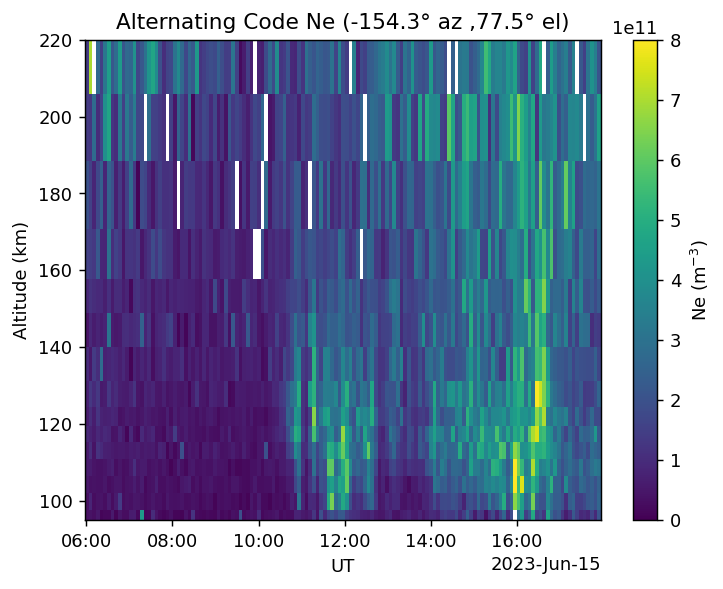

In [11]:
fig,ax=plt.subplots(dpi=130)

pcm = ax.pcolormesh(bdat['time'],bdat['altitude']/1e3,bdat['ne'],
                    vmin=0,vmax=8e11,shading='nearest')

ax.set_ylim([95,220])

locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_xlabel('UT')
ax.set_ylabel('Altitude (km)')
beam_elaz = f"{bdat['azm']:g}\u00b0 az ,{bdat['elm']:g}\u00b0 el"  # \u00b0 is unicode for degrees
ax.set_title(f'Alternating Code Ne ({beam_elaz})')

cb=plt.colorbar(pcm)
cb.set_label('Ne (m$^{-3}$)')

# Questions

1. What is producing the E-region electron density in this plot?

2. How do the density profiles differ before and after 11 UT?

3. Use https://www.gi.alaska.edu/monitors/magnetometer/archive to find the Poker Flat Magnetometer data from this same date and time. Does anything special happen in the magnetometer data that lines up with an event in the PFISR data?